In [0]:
import numpy as np
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import random, os, glob
import matplotlib.pyplot as plt

In [2]:
! unzip data

Archive:  data.zip
   creating: data/cardboard/
  inflating: data/cardboard/cardboard1.jpg  
  inflating: data/cardboard/cardboard10.jpg  
  inflating: data/cardboard/cardboard100.jpg  
  inflating: data/cardboard/cardboard101.jpg  
  inflating: data/cardboard/cardboard102.jpg  
  inflating: data/cardboard/cardboard103.jpg  
  inflating: data/cardboard/cardboard104.jpg  
  inflating: data/cardboard/cardboard105.jpg  
  inflating: data/cardboard/cardboard106.jpg  
  inflating: data/cardboard/cardboard107.jpg  
  inflating: data/cardboard/cardboard108.jpg  
  inflating: data/cardboard/cardboard109.jpg  
  inflating: data/cardboard/cardboard11.jpg  
  inflating: data/cardboard/cardboard110.jpg  
  inflating: data/cardboard/cardboard111.jpg  
  inflating: data/cardboard/cardboard112.jpg  
  inflating: data/cardboard/cardboard113.jpg  
  inflating: data/cardboard/cardboard114.jpg  
  inflating: data/cardboard/cardboard115.jpg  
  inflating: data/cardboard/cardboard116.jpg  
  inflating: dat

In [0]:
dir_path = "data/"

In [0]:
# - The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
# - os implements some useful functions on pathnames. To read or write files see open(), and for accessing the filesystem see the os module. 
# The path parameters can be passed as either strings, or bytes. Applications are encouraged to represent file names as (Unicode) character strings
img_list = glob.glob(os.path.join(dir_path + '*/*.jpg'))

In [5]:
# Verificando tamanho da lista para bater com o total de fotos no dataset - 2527
print(len(img_list))
# Verificando tipos de variaveis 
print(type(img_list))
print(type(img_list[0]))
print(img_list[0])
# Portanto, nesse primeiro Array, capturamos somente o caminho até as imagens

2527
<class 'list'>
<class 'str'>
data/trash/trash104.jpg


In [6]:
# Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).
train = ImageDataGenerator(horizontal_flip = True, 
                           vertical_flip = True, 
                           validation_split = 0.1, 
                           rescale = 1./255, 
                           shear_range = 0.1, 
                           zoom_range = 0.1, 
                           width_shift_range = 0.1,
                           height_shift_range = 0.1
                          )
test = ImageDataGenerator(rescale = 1/255, validation_split = 0.1)
# Lovely flow_from_directory article! https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

train_generator = train.flow_from_directory(dir_path, color_mode = 'rgb', target_size = (200, 200), batch_size = 32, class_mode = 'categorical', subset='training')

test_generator = test.flow_from_directory(dir_path, target_size = (200, 200), color_mode = 'rgb', batch_size = 32, class_mode = 'categorical', subset='validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [0]:
# Makes the classes Dictonary easier to handle
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [0]:
# artigo para entender melhor o que essas layer fazem
# https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/
# Artigo sobre redes neurais aplicadas a imagens - Muito importante para entender nosso problema.
# https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

In [0]:
model = Sequential()
# Input Layer
model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (200, 200, 3), activation = 'relu'))
# Hidden Layers
#   Convolutional
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))

model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
#   Classification
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.3))
# Output Layer
model.add(Dense(6, activation = 'softmax'))


filepath = 'trained_model.h5'
es = EarlyStopping(monitor = 'val_loss', mode = 'max', baseline = 0.2, patience = 200)
checkpoint1 = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint1, es]

In [35]:
# Sumário das diferentes camadas da rede neural e seus autputs
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 50, 50, 32)        18464     
_________________________________________________________________
flatten_9 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)               

In [0]:
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [37]:
model.fit_generator(train_generator, 
                    epochs = 3500, 
                    steps_per_epoch = 2275//32, 
                    validation_data = test_generator,
                    validation_steps = 251//32,
                    callbacks = callbacks_list)

Epoch 1/3500
71/71 [==============================] - 30s 421ms/step - loss: 1.6837 - acc: 0.3112 - val_loss: 1.4530 - val_acc: 0.3705

Epoch 00001: val_acc improved from -inf to 0.37054, saving model to trained_model.h5
Epoch 2/3500
71/71 [==============================] - 29s 414ms/step - loss: 1.4824 - acc: 0.3864 - val_loss: 1.3221 - val_acc: 0.4338

Epoch 00002: val_acc improved from 0.37054 to 0.43379, saving model to trained_model.h5
Epoch 3/3500
71/71 [==============================] - 29s 410ms/step - loss: 1.4288 - acc: 0.4177 - val_loss: 1.4351 - val_acc: 0.4155

Epoch 00003: val_acc did not improve from 0.43379
Epoch 4/3500
71/71 [==============================] - 29s 408ms/step - loss: 1.4059 - acc: 0.4383 - val_loss: 1.3952 - val_acc: 0.4155

Epoch 00004: val_acc did not improve from 0.43379
Epoch 5/3500
71/71 [==============================] - 29s 403ms/step - loss: 1.3081 - acc: 0.4824 - val_loss: 1.2932 - val_acc: 0.5251

Epoch 00005: val_acc improved from 0.43379 to 0

In [0]:
# The model has been trained and saved to the filesystem, now you need to load it and start making predictions with it

# Loading the Model
from keras.models import load_model
model = load_model('trained_model_8_Hlayers.h5')
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [0]:
print("Cardboard = 0 | Glass = 1 | Metal = 2 | Paper = 3 | Plastic = 4 | Trash = 5")

Cardboard = 0 | Glass = 1 | Metal = 2 | Paper = 3 | Plastic = 4 | Trash = 5


In [0]:
# Predicting a single images
img = load_img('plastic800.jpg', target_size = (300, 300))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis = 0)

images = np.vstack([img_array])
classes = model.predict_classes(images, batch_size = 10)
print(classes)

[2]


[1. 1. 1.]


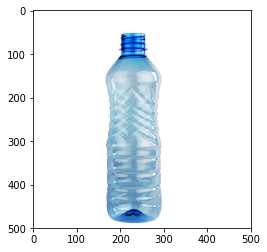

In [0]:
img = load_img('plastic800.jpg')
img_arr = np.expand_dims(img_to_array(img), axis=0)
datagen = ImageDataGenerator(horizontal_flip = True, 
                           vertical_flip = True, 
                           validation_split = 0.1, 
                           rescale = 1./255, 
                           shear_range = 0.1, 
                           zoom_range = 0.1, 
                           width_shift_range = 0.1,
                           height_shift_range = 0.1
                          )

for batch in datagen.flow(img_arr, batch_size=1):
    print(batch[0][0][0])
    plt.imshow(batch[0])
    plt.show()
    break